Number of Clusters: 2
 - DB Index: 1.4800651196081946
 - Cluster Sizes: [122, 78]
----------------------------------------
Number of Clusters: 3
 - DB Index: 1.7792884814663381
 - Cluster Sizes: [81, 60, 59]
----------------------------------------
Number of Clusters: 4
 - DB Index: 1.5535549292825488
 - Cluster Sizes: [71, 45, 43, 41]
----------------------------------------
Number of Clusters: 5
 - DB Index: 1.1685639575493083
 - Cluster Sizes: [46, 41, 41, 36, 36]
----------------------------------------
Number of Clusters: 6
 - DB Index: 1.184185554776948
 - Cluster Sizes: [44, 41, 35, 35, 23, 22]
----------------------------------------
Number of Clusters: 7
 - DB Index: 1.2170006144414056
 - Cluster Sizes: [41, 34, 30, 26, 26, 22, 21]
----------------------------------------
Number of Clusters: 8
 - DB Index: 1.3132325349649305
 - Cluster Sizes: [40, 35, 32, 25, 25, 24, 13, 6]
----------------------------------------
Number of Clusters: 9
 - DB Index: 1.2176756102324844
 - Cluste

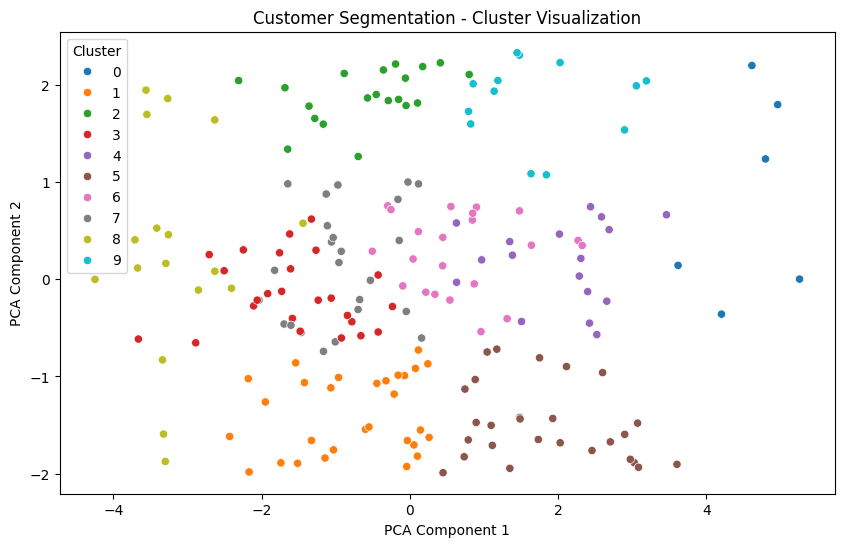

Cluster assignments saved to 'Customer_Clustering.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
transactions_summary = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',      
    'TransactionID': 'count',  
    'Quantity': 'sum',         
    'ProductID': 'nunique'    
}).reset_index()


customer_data = customers.merge(transactions_summary, on='CustomerID', how='left')


customer_data.fillna(0, inplace=True)


customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)
customer_data['SignupDate'] = pd.to_datetime(customer_data['SignupDate'])
customer_data['DaysSinceSignup'] = (customer_data['SignupDate'] - customer_data['SignupDate'].min()).dt.days


scaler = StandardScaler()
numerical_features = customer_data.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1)
scaled_data = scaler.fit_transform(numerical_features)

db_index_values = []

cluster_sizes_dict = {}
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)

    db_index = davies_bouldin_score(scaled_data, cluster_labels)


   
    db_index_values.append(db_index)
    cluster_sizes_dict[k] = pd.Series(cluster_labels).value_counts().tolist()

 
    print(f"Number of Clusters: {k}")
    print(f" - DB Index: {db_index}")
    print(f" - Cluster Sizes: {cluster_sizes_dict[k]}")
    print("-" * 40)


optimal_k = cluster_range[np.argmin(db_index_values)]
print(f"Optimal Number of Clusters: {optimal_k}")
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = final_kmeans.fit_predict(scaled_data)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=customer_data['Cluster'], palette='tab10')
plt.title('Customer Segmentation - Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()
customer_data[['CustomerID', 'Cluster']].to_csv("Customer_Clustering.csv", index=False)
print("Cluster assignments saved to 'Customer_Clustering.csv'.")
